Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLev

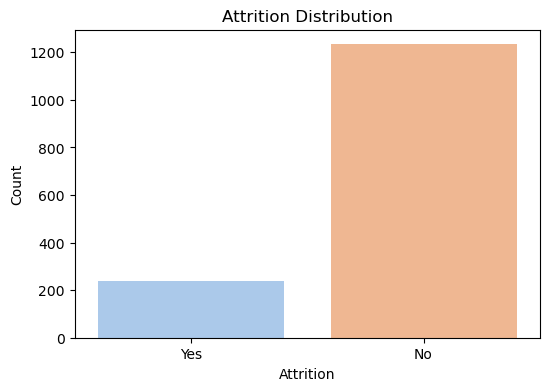

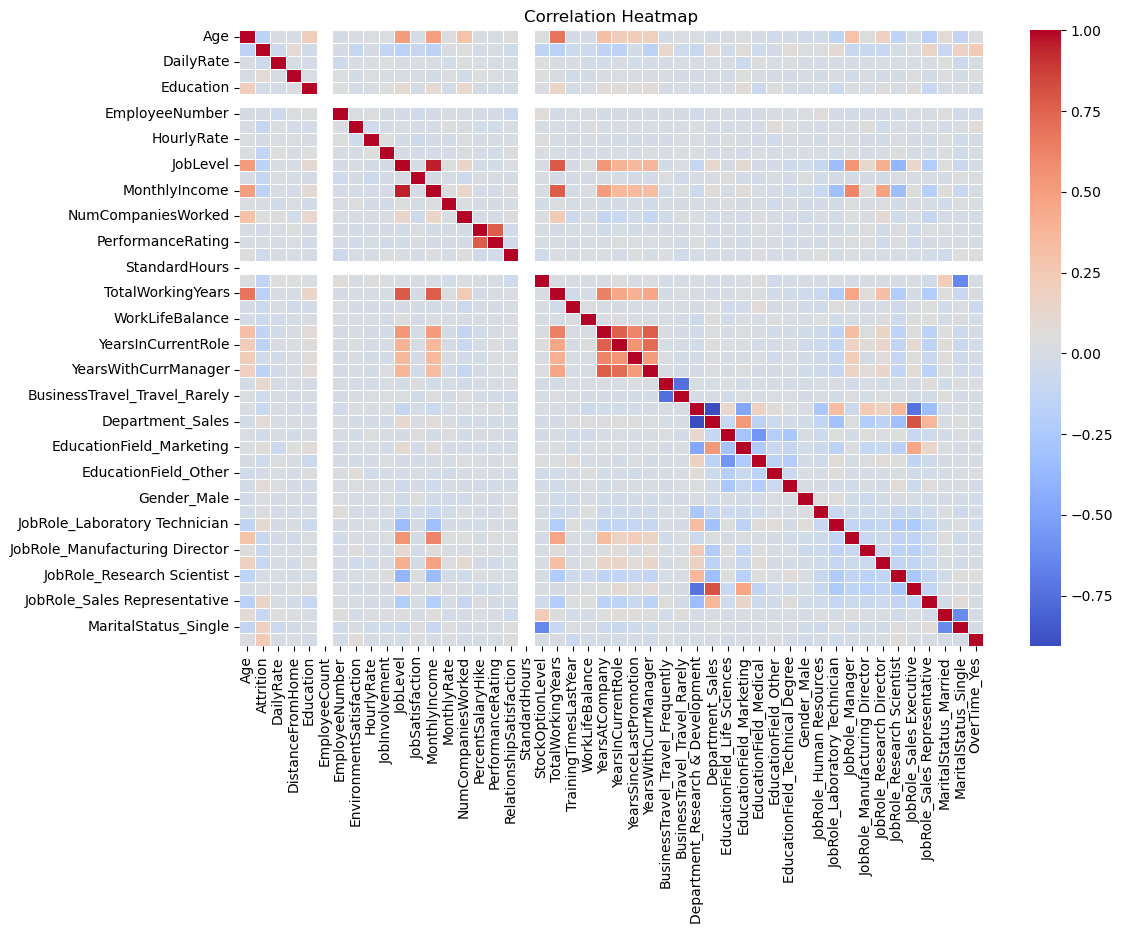

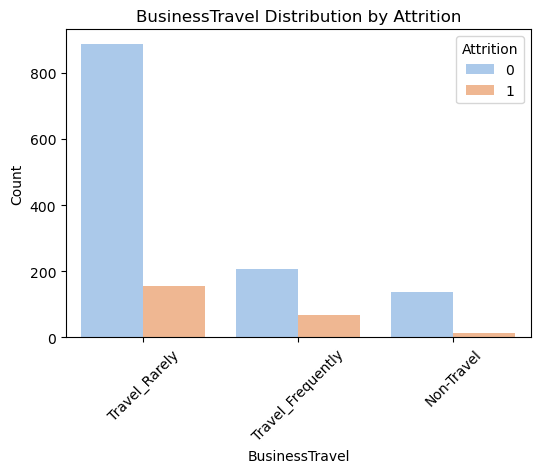

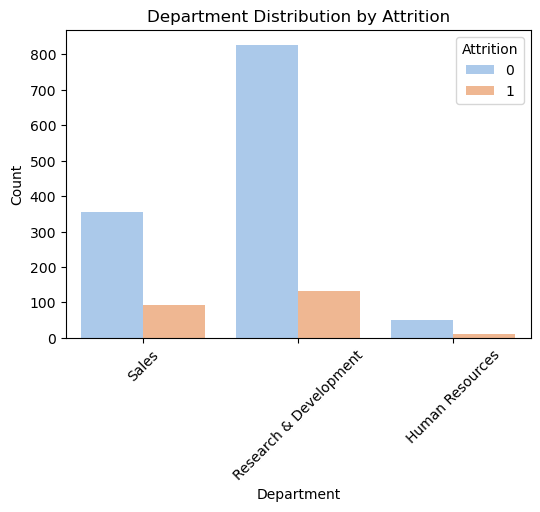

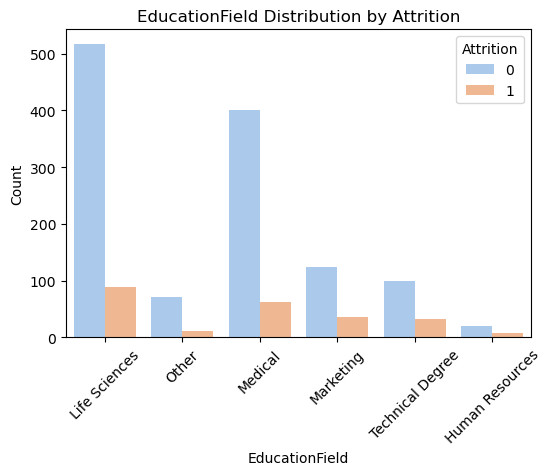

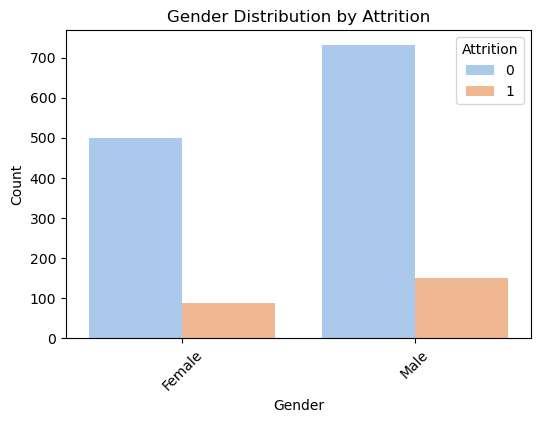

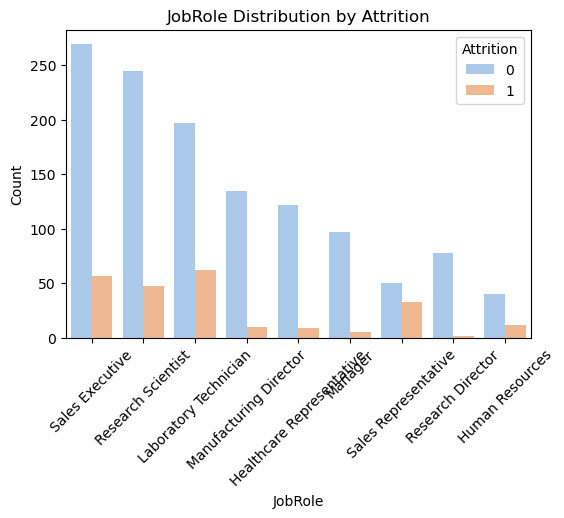

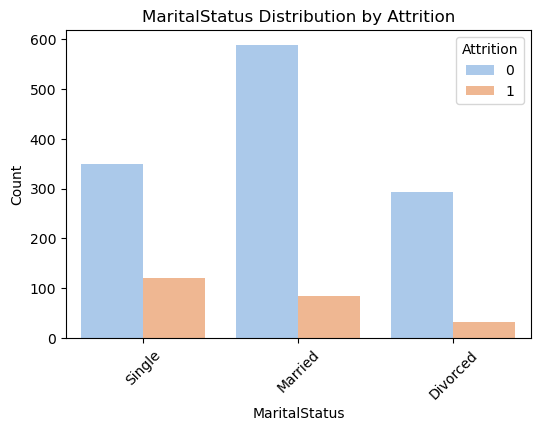

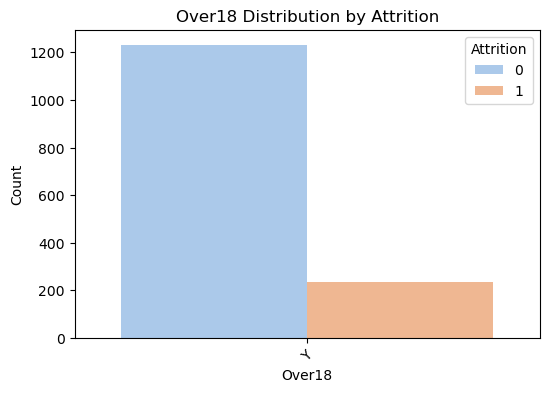

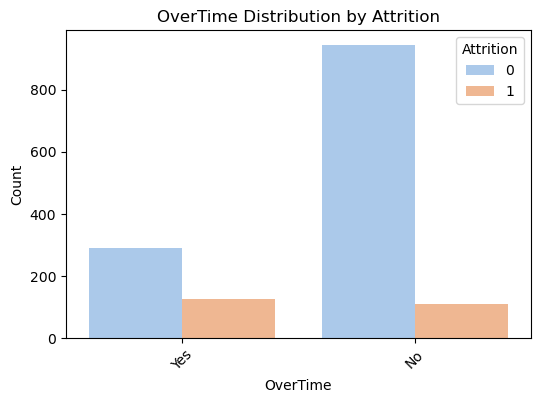

Model: Random Forest
Accuracy: 0.83
Classification Report:
              precision    recall  f1-score     support
0              0.858182  0.955466  0.904215  247.000000
1              0.421053  0.170213  0.242424   47.000000
accuracy       0.829932  0.829932  0.829932    0.829932
macro avg      0.639617  0.562839  0.573319  294.000000
weighted avg   0.788301  0.829932  0.798418  294.000000


Model: Logistic Regression
Accuracy: 0.79
Classification Report:
              precision    recall  f1-score     support
0              0.926606  0.817814  0.868817  247.000000
1              0.407895  0.659574  0.504065   47.000000
accuracy       0.792517  0.792517  0.792517    0.792517
macro avg      0.667250  0.738694  0.686441  294.000000
weighted avg   0.843682  0.792517  0.810506  294.000000


Model: XGBoost
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score     support
0              0.878229  0.963563  0.918919  247.000000
1              0.608696  0.297872  

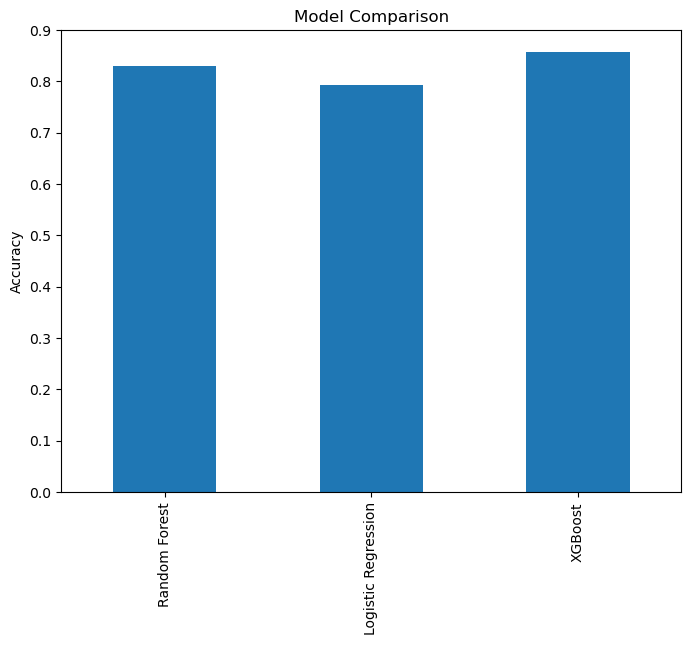

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load Dataset
df = pd.read_csv("IBM-HR-Employee-Attrition.csv")

# EDA: Overview
print("Dataset Overview:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nStatistical Summary:")
print(df.describe())

# EDA: Attrition Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Attrition', palette='pastel')
plt.title('Attrition Distribution')
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.show()

# Ensure the target column and categorical columns are encoded
if df['Attrition'].dtype == 'object':
    df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Perform one-hot encoding for all categorical columns
df_encoded = pd.get_dummies(df, drop_first=True)

# Generate the correlation heatmap using the encoded DataFrame
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# EDA: Categorical Variable Analysis
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, hue='Attrition', palette='pastel')
    plt.title(f'{col} Distribution by Attrition')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Drop irrelevant columns
irrelevant_cols = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
df.drop(columns=irrelevant_cols, inplace=True)

# Feature Engineering: Derived Features
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 100], labels=['<25', '25-35', '35-45', '45-55', '>55'])
df['YearsInCompanyGroup'] = pd.cut(df['YearsAtCompany'], bins=[-1, 1, 5, 10, 20, 100], labels=['<1', '1-5', '5-10', '10-20', '>20'])

# One-Hot Encode all categorical variables
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop(columns=['Attrition'])
y = df['Attrition']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate each model
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Save results
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'classification_report': report
    }

# Display Results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print("Classification Report:")
    print(pd.DataFrame(result['classification_report']).transpose())
    print("\n")

# Compare Performance
comparison = pd.DataFrame({
    model_name: {'Accuracy': result['accuracy']} 
    for model_name, result in results.items()
}).transpose()

comparison.plot(kind='bar', figsize=(8, 6), legend=False)
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.show()


In [2]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Define parameter grids for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
        'solver': ['liblinear', 'lbfgs']
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0]
    }
}

# Initialize models
base_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Perform hyperparameter tuning
optimized_models = {}
for model_name, model in base_models.items():
    print(f"Tuning {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        scoring='f1',  # Use F1-score for imbalanced datasets
        cv=3,  # 3-fold cross-validation
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X_train_balanced, y_train_balanced)
    optimized_models[model_name] = grid_search.best_estimator_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print("\n")

# Evaluate optimized models
results = {}
for model_name, model in optimized_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'classification_report': report
    }

# Display Results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {result['accuracy']:.2f}")
    print("Classification Report:")
    print(pd.DataFrame(result['classification_report']).transpose())
    print("\n")


Tuning Random Forest...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Tuning Logistic Regression...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Logistic Regression: {'C': 1, 'solver': 'lbfgs'}


Tuning XGBoost...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.6}


Model: Random Forest
Accuracy: 0.83
Classification Report:
              precision    recall  f1-score     support
0              0.858182  0.955466  0.904215  247.000000
1              0.421053  0.170213  0.242424   47.000000
accuracy       0.829932  0.829932  0.829932    0.829932
macro avg      0.639617  0.562839  0.573319  294.000000
weighted avg   0.788301  0.829932  0.798418  294.000000


Model: Logistic Regression
Accuracy: 0.79

In [3]:
import joblib

# Save models
joblib.dump(optimized_models['Random Forest'], "random_forest_model.pkl")
joblib.dump(optimized_models['Logistic Regression'], "logistic_regression_model.pkl")
joblib.dump(optimized_models['XGBoost'], "xgboost_model.pkl")
# Save scaler
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [4]:
import joblib

# Save models
joblib.dump(results['Random Forest']['model'], "random_forest_model.pkl")
joblib.dump(results['Logistic Regression']['model'], "logistic_regression_model.pkl")
joblib.dump(results['XGBoost']['model'], "xgboost_model.pkl")

# Save scaler
joblib.dump(scaler, "scaler.pkl")

# Save feature names
feature_names = X.columns  # Get the column names after preprocessing
joblib.dump(feature_names, "feature_names.pkl")


['feature_names.pkl']